In [59]:
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
image_path = "./datasets/mbappe/gettyimages-1477251906-612x612.jpg"
img = cv2.imread(image_path)
img.shape

(408, 612, 3)

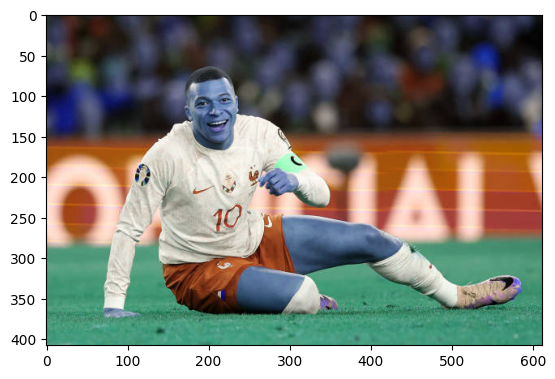

In [5]:
plt.imshow(img)

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(408, 612)

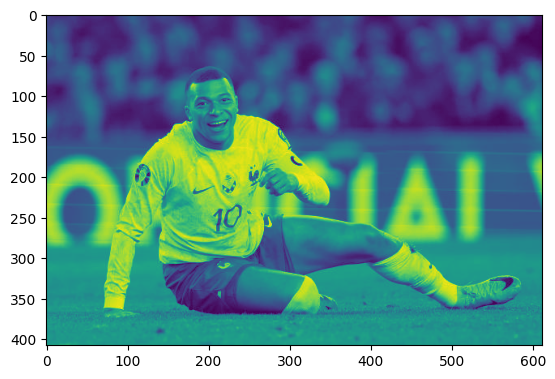

In [7]:
plt.imshow(gray)

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [9]:
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
faces

array([[175,  83,  67,  67]], dtype=int32)

In [10]:
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

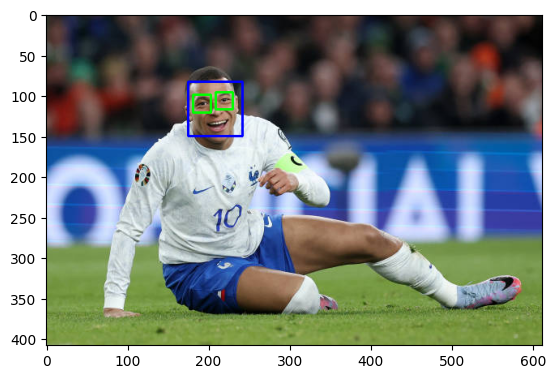

In [11]:
# Convert BGR image to RGB for matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the output with matplotlib
plt.figure()
plt.imshow(img_rgb, cmap="gray")
# plt.imshow(img_rgb)
# plt.axis("off")
plt.show()

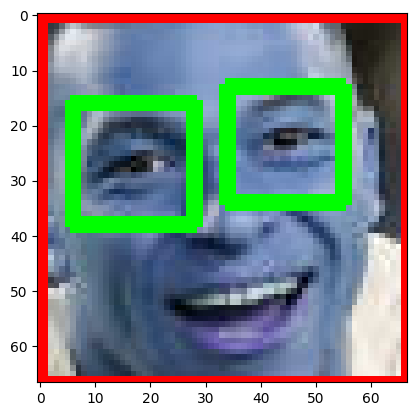

In [12]:
plt.imshow(roi_color, cmap="gray")

## Data Cleaning and Preprocessing

We create a new function called "detect_faces_and_eyes :
* take the path to an image as input and 
* display the image with rectangles drawn around detected faces and eyes

In [13]:
import cv2
import matplotlib.pyplot as plt

# function to detect faces and eyes using opencv
def detect_faces_and_eyes(image_path):
    # Load Haar Cascade Classifiers for face and eyes
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Read the image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5, minSize=(30,30))

    # Detect eyes within each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)

    # Convert BGR image to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the output with matplotlib
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()
    

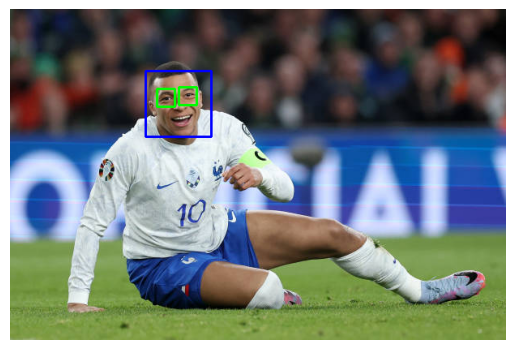

In [14]:
detect_faces_and_eyes(image_path=image_path)

We need a function tat will crop faces from image folder 
* create a new folder named face_crop (if it doesn't exist),
* and within that, create a new folder named after the original image's folder. 
* It will save cropped images only if both eyes and the face are detected

In [15]:
import cv2
import os
import glob

def crop_faces_from_folder(folder_path):
    # Load Haar Cascade Classifiers
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Create the face_crop directory if it doesn't exist
    target_folder = os.path.join('face_crop', os.path.basename(folder_path))
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)
    else:
        # Clear the existing folder content
        for file in os.listdir(target_folder):
            os.remove(os.path.join(target_folder, file))

    # Process each image in the folder
    for image_file in glob.glob(os.path.join(folder_path, '*.jpg')):
        img = cv2.imread(image_file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Process each face detected
        for i, (x, y, w, h) in enumerate(faces, start=1):
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]

            # Detect eyes in the face region
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:  # Check if at least two eyes are detected
                cropped_face = img[y:y+h, x:x+w]
                base_name = os.path.basename(image_file).split('.')[0]
                cv2.imwrite(os.path.join(target_folder, f'face_{base_name}_{i}.jpg'), cropped_face)


    print(f"Cropped faces saved in {target_folder}")




In [28]:
# run the code for each player folder
crop_faces_from_folder("./datasets/mbappe")
crop_faces_from_folder("./datasets/ronaldo")
crop_faces_from_folder("./datasets/messi")
crop_faces_from_folder("./datasets/oshoala")
crop_faces_from_folder("./datasets/morgan")

Cropped faces saved in face_crop/mbappe
Cropped faces saved in face_crop/ronaldo
Cropped faces saved in face_crop/messi
Cropped faces saved in face_crop/oshoala
Cropped faces saved in face_crop/morgan


Next step is to tranform our image using wavelet transformation technique
* using PyWavelets

To create a dictionary where the keys are the names of cropped folders (e.g., 'mbappe') and the values are lists of all cropped images in the folder

In [29]:
def create_crop_images_dict(base_folder):
    crop_images_dict = {}
    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        if os.path.isdir(folder_path):
            crop_images_dict[folder_name] = [
                img for img in os.listdir(folder_path) if img.endswith(".jpg")
            ]
    return crop_images_dict


In [30]:
# Example usage
crop_images_dict = create_crop_images_dict("./face_crop")
print(crop_images_dict.keys())

dict_keys(['oshoala', 'mbappe', 'ronaldo', 'messi', 'morgan'])


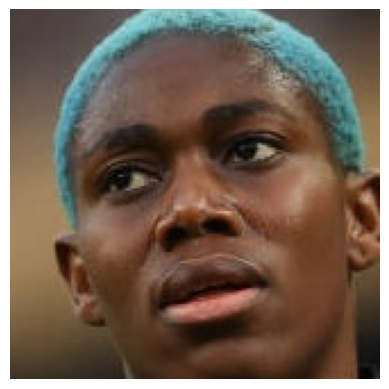

In [31]:
import cv2
import matplotlib.pyplot as plt

folder_name = "oshoala"
image_name = crop_images_dict[folder_name][0]
image_path = os.path.join("./face_crop", folder_name, image_name)

# Read the image
img = cv2.imread(image_path)

# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [32]:
import pywt


def wavelet_transform_on_dict_images(crop_images_dict, base_folder):
    for folder_name, image_files in crop_images_dict.items():
        for image_file in image_files:
            image_path = os.path.join(base_folder, folder_name, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Perform 2D Discrete Wavelet Transform
            coeffs2 = pywt.dwt2(img, "haar")
            LL, (LH, HL, HH) = coeffs2

            # Display the transformed image
            fig, axs = plt.subplots(2, 2, figsize=(10, 10))
            for i, a in enumerate([LL, LH, HL, HH]):
                axs[i // 2, i % 2].imshow(a, cmap="gray")
                axs[i // 2, i % 2].set_title(["LL", "LH", "HL", "HH"][i])
                axs[i // 2, i % 2].axis("off")
            plt.suptitle(f"Wavelet Transform of {image_file}")
            plt.show()



In [33]:
def wavelet_transform_on_dict_images(crop_images_dict, base_folder):
    X = []  # List to hold transformed images
    Y = []  # List to hold corresponding keys

    for folder_name, image_files in crop_images_dict.items():
        for image_file in image_files:
            image_path = os.path.join(base_folder, folder_name, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Perform 2D Discrete Wavelet Transform
            coeffs2 = pywt.dwt2(img, "haar")
            LL, (LH, HL, HH) = coeffs2

            # Append the transformed image (LL component) and the key to the lists
            # resize the image to common size
            # Define the common size for all images
            common_size = (200, 100)

            # Resize, flatten, and convert X to float, then create a NumPy array
            LL = cv2.resize(LL, common_size).flatten()
            X.append(LL)
            Y.append(folder_name)

    return X, Y


In [34]:
# Assign to X and Y
crop_images_dict = create_crop_images_dict("./face_crop")
X, Y = wavelet_transform_on_dict_images(crop_images_dict, "./face_crop")

In [35]:
set(Y)

{'mbappe', 'messi', 'morgan', 'oshoala', 'ronaldo'}

In [36]:
X[0]

array([129.5       , 129.72999904, 130.54999995, ...,  90.77495575,
       102.66506195, 106.        ])

In [37]:
len(X)

250

In [38]:
len(X[0])

20000

In [39]:
# convert each image in X to float and NumPy array
X = np.array(X).astype(float)

# Mapping dictionary
label_mapping = {"oshoala": 0, "mbappe": 1, "ronaldo": 2, "messi": 3, "morgan": 4}


# Convert labels in Y to numbers
label= [label_mapping[label] for label in Y]

In [40]:
X.shape

(250, 20000)

In [41]:
X[0], Y[-1], label[-1]

(array([129.5       , 129.72999904, 130.54999995, ...,  90.77495575,
        102.66506195, 106.        ]),
 'morgan',
 4)

## Modeling

We will use a simple svm model to train our model

In [287]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Splitting the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, label, test_size=0.2, random_state=42
)

# Initialize the SVM classifier
svm = SVC(kernel="linear", C=10)  # You can experiment with different kernels

# Train the classifier
svm.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = svm.predict(X_test)

# Evaluate the classifier
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.80      0.80      0.80         5
           2       0.82      0.75      0.78        12
           3       0.93      1.00      0.96        13
           4       1.00      0.86      0.92         7

    accuracy                           0.90        50
   macro avg       0.90      0.88      0.89        50
weighted avg       0.90      0.90      0.90        50



In [288]:
svm.score(X_test, Y_test), svm.score(X_train, Y_train),

(0.9, 1.0)

In [289]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="linear", C=10))])
pipe.fit(X_train, Y_train)
pipe.score(X_test, Y_test)

0.94

In [290]:
# Mapping dictionary
label_mapping = {"oshoala": 1, "mbappe": 2, "ronaldo": 3, "messi": 4, "morgan": 5}

# Evaluate the classifier
print(classification_report(Y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.80      0.89         5
           2       0.91      0.83      0.87        12
           3       0.93      1.00      0.96        13
           4       1.00      1.00      1.00         7

    accuracy                           0.94        50
   macro avg       0.95      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50



In [291]:
# let try randomforest
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([("scaler", StandardScaler()), ("randomforest", RandomForestClassifier(n_estimators=100, max_features=3))])
pipe.fit(X_train, Y_train)
pipe.score(X_test, Y_test)

0.76

In [294]:
# xgboost
from xgboost import XGBClassifier

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("xgboost", XGBClassifier()),
    ]
)
pipe.fit(X_train, Y_train)
pipe.score(X_train, Y_train), pipe.score(X_test, Y_test)

(1.0, 0.82)

In [295]:
# Adjusted mapping
label_mapping = {"oshoala": 0, "mbappe": 1, "ronaldo": 2, "messi": 3, "morgan": 4}

# Evaluate the classifier
print(classification_report(Y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.40      0.40      0.40         5
           2       0.73      0.67      0.70        12
           3       1.00      0.85      0.92        13
           4       0.78      1.00      0.88         7

    accuracy                           0.82        50
   macro avg       0.77      0.78      0.77        50
weighted avg       0.82      0.82      0.82        50



In [297]:
# xgboost
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logistic", LogisticRegression(solver="liblinear")),
    ]
)
pipe.fit(X_train, Y_train)
pipe.score(X_test, Y_test)

0.88

Since svm did best, let use GridSearch to try to get best model param

In [263]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define a pipeline with a scaler and an SVM classifier
pipeline = Pipeline([("scaler", StandardScaler()), ("svm", SVC())])

# Define the parameter grid for GridSearch
param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__gamma": ["scale", "auto"],
    "svm__kernel": ["linear", "rbf", "poly"],
}

# Create GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, Y_train) 

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.3s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.4s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.4s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.4s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.4s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.5s
[CV] END .....svm__C=0.1, svm__gamma=scale, svm__kernel=poly; total time=   0.3s
[CV] END .....svm__C=0.1, svm__gamma=scale, svm__kernel=poly; total time=   0.3s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__

We just gonna use the base svm since it does much better than the gridsearch model

In [305]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="linear", C=10, probability=True))])
pipe.fit(X_train, Y_train)
pipe.score(X_test, Y_test), pipe.predict_proba(X_test)

(0.94,
 array([[6.06442180e-01, 6.55652011e-02, 2.76812759e-01, 2.09931140e-02,
         3.01867459e-02],
        [9.91506921e-01, 1.07022972e-03, 1.29232873e-03, 2.72806068e-03,
         3.40245960e-03],
        [3.60462610e-03, 7.95529859e-03, 8.28983847e-01, 1.43012167e-01,
         1.64440608e-02],
        [5.65515021e-03, 4.50719900e-01, 2.96596274e-01, 1.98670976e-01,
         4.83576996e-02],
        [1.59314074e-02, 1.78224861e-01, 6.07940181e-01, 1.00221753e-01,
         9.76817981e-02],
        [5.09418778e-03, 7.78917961e-03, 1.65033525e-02, 9.69784982e-01,
         8.28298180e-04],
        [9.63660367e-03, 6.06621019e-02, 5.51001278e-02, 8.52467162e-01,
         2.21340043e-02],
        [3.23482730e-03, 1.06170338e-02, 2.85872102e-02, 9.46969092e-01,
         1.05918368e-02],
        [8.83453989e-01, 3.74669952e-02, 2.53984517e-02, 3.15532801e-02,
         2.21272843e-02],
        [2.18063765e-02, 2.86207194e-01, 2.34938422e-01, 1.14771826e-01,
         3.42276181e-01],
   

In [306]:
from joblib import dump

# Save the model to a file
dump(pipe, "svm_pipeline_model.joblib")

['svm_pipeline_model.joblib']

In [307]:
from joblib import load

model = load("svm_pipeline_model.joblib")
# Evaluate the classifier
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.80      0.89         5
           2       0.91      0.83      0.87        12
           3       0.93      1.00      0.96        13
           4       1.00      1.00      1.00         7

    accuracy                           0.94        50
   macro avg       0.95      0.93      0.94        50
weighted avg       0.94      0.94      0.94        50



In [301]:
X_test[0], X_train[0]


(array([ 62.        ,  61.50000149,  54.5       , ..., 431.125     ,
        430.07500458, 430.        ]),
 array([26.        , 26.00000063, 26.        , ..., 62.        ,
        62.        , 62.        ]))

In [309]:
print(model.predict(X_test[20].reshape(1, -1)))
print(model.predict_proba(X_test[20].reshape(1,-1)))
print(Y_test[20])

[4]
[[0.01779124 0.01706987 0.03285482 0.10840135 0.82388271]]
4
